<a href="https://colab.research.google.com/github/Check-Your-Skin/checkyourskin-ml_model/blob/train-cnn-ham10000/Data%20Preparation/Resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U albumentations

In [2]:
import albumentations as A
import cv2
import os
import shutil
from glob import glob
from PIL import Image
from google.colab.patches import cv2_imshow
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample



import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/HAM10000/')

In [5]:
shutil.rmtree('/content/HAM10000/ham10000_images_part_1')
shutil.rmtree('/content/HAM10000/ham10000_images_part_2')

In [6]:
resize_dest_dir = '/content/HAM10000/HAM10000_images/'
data = glob('/content/HAM10000/*')
try:
  os.mkdir(resize_dest_dir)
except:
  pass
for dir in data:
  if os.path.isdir(dir):
    images = glob(f'{dir}/*')
    for image in images:
      shutil.copy(image, resize_dest_dir)

In [7]:
print(len(glob('/content/HAM10000/HAM10000_images/*')))

10015


In [8]:
shutil.rmtree('/content/HAM10000/HAM10000_images_part_1')
shutil.rmtree('/content/HAM10000/HAM10000_images_part_2')

In [9]:
#Load Dataframe
file_path = '/content/HAM10000/HAM10000_metadata.csv'
df = pd.read_csv(file_path)

In [10]:
#Adding numerical lable for one-hot encoding
numerical_label = LabelEncoder().fit(df['dx']).transform(df['dx'])
df['label'] = numerical_label

In [11]:
for label in range(7):
  print(label,': ',len(df[df['label'] == label]))

0 :  327
1 :  514
2 :  1099
3 :  115
4 :  1113
5 :  6705
6 :  142


###Create new Dataframe with Balanced Labels

In [ ]:
sample_size = 800
df_aug = df.iloc[:0,:].copy()
df_normal = df.iloc[:0,:].copy()
for label in range(7):
  aug_count = sample_size - len(df[df['label'] == label])
  if aug_count > 0:
    df_temp = df[df['label']==label]
    df_normal = pd.concat([df_temp, df_normal])

    df_temp = df[df['label']==label].sample(n=aug_count, random_state=42, replace=True)
    df_aug = pd.concat([df_temp, df_aug])
  else:
    df_temp = df[df['label']==label].sample(n=sample_size, random_state=42)
    df_normal = pd.concat([df_temp, df_normal])

df_aug = df_aug.reset_index(drop=True)

In [50]:
print("Number of original images: ",len(df_normal))
print('Number of augumented images: ',len(df_aug))

Number of original images:  3498
Number of augumented images:  2102


In [45]:
#Alter Name of Augumented Images
for i, row in df_aug.iterrows():
  new_id = row['image_id'] + 'AUG' + format(i,'04d')
  df_aug.at[i,'image_id'] = new_id
df_aug

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0006796,ISIC_0025707AUG0000,vasc,consensus,35.0,male,trunk,6
1,HAM_0000934,ISIC_0031706AUG0001,vasc,consensus,60.0,male,trunk,6
2,HAM_0002218,ISIC_0025578AUG0002,vasc,histo,5.0,male,back,6
3,HAM_0005215,ISIC_0028406AUG0003,vasc,consensus,80.0,male,abdomen,6
4,HAM_0001566,ISIC_0031346AUG0004,vasc,consensus,70.0,female,face,6
...,...,...,...,...,...,...,...,...
2097,HAM_0000859,ISIC_0029715AUG2097,akiec,histo,70.0,male,lower extremity,0
2098,HAM_0001036,ISIC_0027588AUG2098,akiec,histo,50.0,female,face,0
2099,HAM_0001277,ISIC_0031927AUG2099,akiec,histo,75.0,male,chest,0
2100,HAM_0006560,ISIC_0028063AUG2100,akiec,histo,50.0,male,face,0


In [34]:
#create augmented images
transform = A.Compose([
    A.GridDistortion(num_steps=6, distort_limit=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

def augumentation(img):
  img_name = img.split('AUG',1)[0] + ".jpg"
  base_path = "/content/HAM10000/HAM10000_images/"
  img_path = os.path.join(base_path,img_name)
  # Read an image with OpenCV and convert it to the RGB colorspace
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Augment an image
  transformed = transform(image=image)
  transformed_image = transformed["image"]
  new_path = base_path + img + '.jpg'
  cv2.imwrite(new_path, transformed_image)


In [55]:
id_list = df_aug['image_id'].tolist()
for id in id_list:
  augumentation(id)

In [59]:
df_resampled = pd.concat([df_aug,df_normal])
df_resampled = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)
df_resampled['label'].value_counts()

1    800
2    800
0    800
5    800
4    800
3    800
6    800
Name: label, dtype: int64

###Augumentation

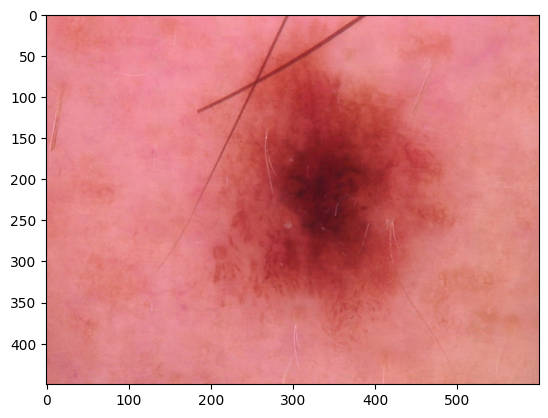

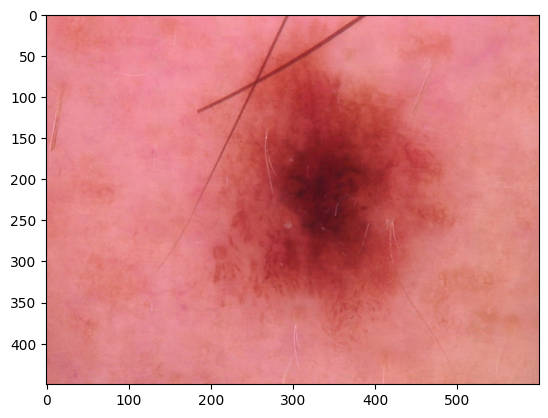

In [ ]:
transform = A.Compose([
    A.GridDistortion(num_steps=6, distort_limit=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])
# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("/content/HAM10000/HAM10000_images/ISIC_0024306.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]
plt.imshow(transformed_image)
plt.show()

In [ ]:
#Dictionary to match the Image_id with the Path of the Image
imgPath = {}
for x in glob(os.path.join('/content/HAM10000/HAM10000_images/*.jpg')):
    imgPath[os.path.splitext(os.path.basename(x))[0]] = x

In [60]:
#Add Resized Image data to DataFrame

size = (128,128)
df_resampled['image'] = df_resampled['image_id'].map(imgPath.get).map(lambda x: np.asarray(Image.open(x).resize(size)))
df_resampled.to_csv('/content/drive/My Drive/ML-Models/HAM10000.csv', index=False)